In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 기호 정상 표시
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 수집 함수
def fetch_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    주어진 티커의 데이터를 yfinance를 사용해 다운로드
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# 실행: Cintas Corporation (CTAS) 데이터를 가져오기
data = fetch_data("CTAS", "2020-01-01", "2023-01-01")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.464996,67.707497,66.644997,67.697502,59.493404,2176800
2020-01-03,67.017502,67.995003,66.767502,67.392502,59.225376,1972400
2020-01-06,67.032501,67.587502,66.695000,67.567497,59.379150,1636800
2020-01-07,67.029999,67.812500,66.834999,67.517502,59.335228,1553600
2020-01-08,67.692497,68.955002,67.224998,68.820000,60.479866,2808400


In [3]:
# 팩터 계산 함수
def calculate_factors(data: pd.DataFrame) -> pd.DataFrame:
    """
    주어진 데이터에서 주요 팩터를 계산
    """
    # 모멘텀 팩터
    data['Momentum'] = data['Close'] / data['Close'].shift(12) - 1
    
    # 단순 이동 평균 (SMA)
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    
    # RSI 계산
    data['RSI'] = calculate_rsi(data['Close'], 14)
    
    # 변동성
    data['Volatility'] = data['Close'].pct_change().rolling(window=14).std()
    
    return data

def calculate_rsi(series: pd.Series, window: int) -> pd.Series:
    """
    RSI(Relative Strength Index) 계산
    """
    delta = series.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# 팩터 계산 실행
data = calculate_factors(data)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Momentum,SMA_50,SMA_200,RSI,Volatility
Date,,,,,,,,,,,
2022-12-23,112.757500,114.372498,112.002502,114.309998,109.201096,820400,0.008736,109.16830,102.218963,NaN,0.018467
2022-12-27,114.775002,115.507500,113.985001,114.757500,109.628593,1270400,0.008547,109.55665,102.331125,NaN,0.018001
2022-12-28,115.209999,116.157501,112.739998,112.760002,107.720367,1062800,-0.005337,109.84160,102.426163,NaN,0.018670
2022-12-29,113.562500,114.834999,113.375000,114.237503,109.131828,1010000,-0.001028,110.11595,102.519713,NaN,0.018981
2022-12-30,113.367500,113.857498,111.470001,112.904999,107.858894,1249600,-0.023355,110.37280,102.597825,NaN,0.019233


In [4]:
# RSI 계산 함수
def calculate_rsi(series: pd.Series, window: int) -> pd.Series:
    """
    RSI(Relative Strength Index) 계산
    """
    delta = series.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 팩터 재계산
data['RSI'] = calculate_rsi(data['Close'], 14)

# 결과 확인
data[['Close', 'RSI']].tail(20)  # 끝에서 20개 데이터 확인

,Close,RSI
Date,,
2022-12-02,115.632500,NaN
2022-12-05,114.852501,NaN
2022-12-06,113.154999,NaN
2022-12-07,113.320000,NaN
2022-12-08,113.785004,NaN
2022-12-09,113.364998,NaN
2022-12-12,114.355003,NaN
2022-12-13,115.605003,NaN
2022-12-14,114.820000,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        756 non-null    float64
 1   High        756 non-null    float64
 2   Low         756 non-null    float64
 3   Close       756 non-null    float64
 4   Adj Close   756 non-null    float64
 5   Volume      756 non-null    int64  
 6   Momentum    744 non-null    float64
 7   SMA_50      707 non-null    float64
 8   SMA_200     557 non-null    float64
 9   RSI         0 non-null      float64
 10  Volatility  742 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 70.9 KB


In [6]:
# RSI 계산 함수 수정
def calculate_rsi(series: pd.Series, window: int) -> pd.Series:
    """
    Relative Strength Index (RSI) 계산
    """
    delta = series.diff()  # 종가 변화
    gain = np.where(delta > 0, delta, 0)  # 상승분
    loss = np.where(delta < 0, -delta, 0)  # 하락분
    
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    
    # 평균 하락분이 0인 경우 처리 (RSI는 100으로 설정)
    rs = np.where(avg_loss == 0, 0, avg_gain / avg_loss)
    rsi = 100 - (100 / (1 + rs))
    
    return pd.Series(rsi, index=series.index)

# 수정된 RSI 계산 적용
data['RSI'] = calculate_rsi(data['Close'], 14)

# 결과 확인
data[['Close', 'RSI']].tail(20)

,Close,RSI
Date,,
2022-12-02,115.632500,76.909813
2022-12-05,114.852501,70.547791
2022-12-06,113.154999,58.946167
2022-12-07,113.320000,58.719203
2022-12-08,113.785004,63.842223
2022-12-09,113.364998,55.321356
2022-12-12,114.355003,59.216156
2022-12-13,115.605003,58.566603
2022-12-14,114.820000,54.359550


In [7]:
# 데이터 처리 함수
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    결측치를 처리하고 학습에 필요한 데이터 준비
    """
    data = data.dropna()  # 결측치 제거
    features = ['Momentum', 'SMA_50', 'SMA_200', 'RSI', 'Volatility']  # 주요 팩터
    target = 'Close'  # 예측할 변수
    
    X = data[features]
    y = data[target].shift(-1)  # 다음날 종가를 타겟으로 설정
    X, y = X[:-1], y[:-1]  # 정렬
    return X, y

# 데이터 처리 실행
X, y = preprocess_data(data)
print(f"Feature Data Shape: {X.shape}")
print(f"Target Data Shape: {y.shape}")

Feature Data Shape: (556, 5)
Target Data Shape: (556,)


In [8]:
# 데이터 분리 (학습/테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 예측
y_pred = model.predict(X_test_scaled)

# 결과 출력
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3.621225733404972


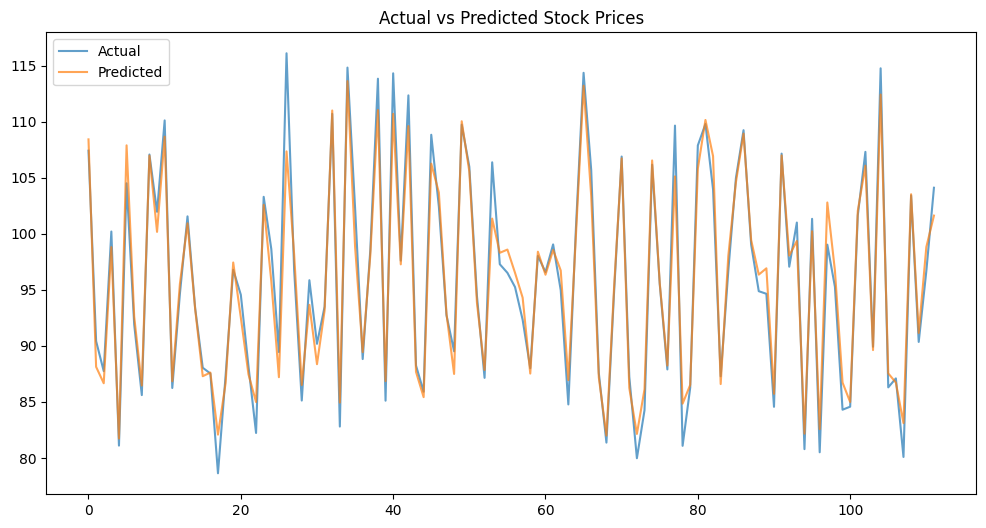

In [9]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

# 함수로 만들어보자

In [ ]:
# 데이터 수집 함수
def fetch_data(ticker: str) -> pd.DataFrame:
    """
    티커의 데이터를 2020-01-01부터 현재까지 yfinance를 통해 다운로드
    """
    start_date = "2020-01-01"
    end_date = datetime.now().strftime('%Y-%m-%d')
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# RSI 계산 함수 (결측치 방지)
def calculate_rsi(series: pd.Series, window: int) -> pd.Series:
    """
    RSI(Relative Strength Index) 계산
    """
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)  # 상승분
    loss = np.where(delta < 0, -delta, 0)  # 하락분
    
    # 초기 평균 처리
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()
    
    # 분모가 0인 경우 방지
    rs = np.where(avg_loss == 0, 0, avg_gain / avg_loss)
    rsi = 100 - (100 / (1 + rs))
    
    return pd.Series(rsi, index=series.index)

# 팩터 계산 함수
def calculate_factors(data: pd.DataFrame) -> pd.DataFrame:
    """
    데이터에서 주요 팩터를 계산
    """
    data['Momentum'] = data['Close'] / data['Close'].shift(12) - 1
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(data['Close'], 14)
    data['Volatility'] = data['Close'].pct_change().rolling(window=14).std()
    return data

# 데이터 처리 함수
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    결측치를 처리하고 학습에 필요한 데이터 준비
    """
    data = data.dropna()  # 결측치 제거
    features = ['Momentum', 'SMA_50', 'SMA_200', 'RSI', 'Volatility']  # 주요 팩터
    target = 'Close'  # 예측할 변수
    X = data[features]
    y = data[target].shift(-1)  # 다음날 종가를 타겟으로 설정
    X, y = X[:-1], y[:-1]  # 정렬
    return X, y

# 티커 입력만으로 전체 실행
def evaluate_stock(ticker: str):
    """
    티커를 입력 받아 현재 주가, 예측 주가, 추천 여부를 출력 및 그래프 표시
    """
    try:
        # 데이터 수집
        data = fetch_data(ticker)
        
        # 팩터 계산
        data = calculate_factors(data)
        
        # 데이터 처리
        X, y = preprocess_data(data)
        
        # 데이터 충분성 확인
        if len(y) < 2:
            raise ValueError("데이터가 부족하여 예측을 진행할 수 없습니다. 더 긴 기간의 데이터를 사용하세요.")
        
        # 데이터 분리 (훈련/테스트)
        X_train, X_test = X[:-1], X[-1:]  # 마지막 데이터를 테스트로 사용
        y_train = y[:-1]  # 마지막 날 이전 데이터를 학습 데이터로 사용
        current_price = y.iloc[-1]  # 현재 종가
        
        # 데이터 스케일링
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 모델 학습
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # 예측
        predicted_price = model.predict(X_test_scaled)[0]
        
        # 추천 여부 판단
        recommendation = "구매 추천" if predicted_price > current_price else "구매 비추천"
        
        # 결과 출력
        print(f"티커: {ticker}")
        print(f"현재 주가: {current_price:.2f}")
        print(f"예측 주가: {predicted_price:.2f}")
        print(f"추천 여부: {recommendation}")
        
        # 최근 30일 주가 및 예측 주가 시각화
        plt.figure(figsize=(12, 6))
        plt.plot(data['Close'][-30:], label='최근 30일 종가', marker='o')
        plt.axhline(predicted_price, color='r', linestyle='--', label='예측 종가')
        plt.title(f"{ticker} 최근 30일 종가 및 예측 종가")
        plt.xlabel("날짜")
        plt.ylabel("가격")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    except Exception as e:
        print(f"오류 발생: {e}")
        print("데이터를 확인하거나 기간을 조정해 다시 시도하세요.")



[*********************100%%**********************]  1 of 1 completed


티커: 251270.KS
현재 주가: 46850.00
예측 주가: 47039.00
추천 여부: 구매 추천


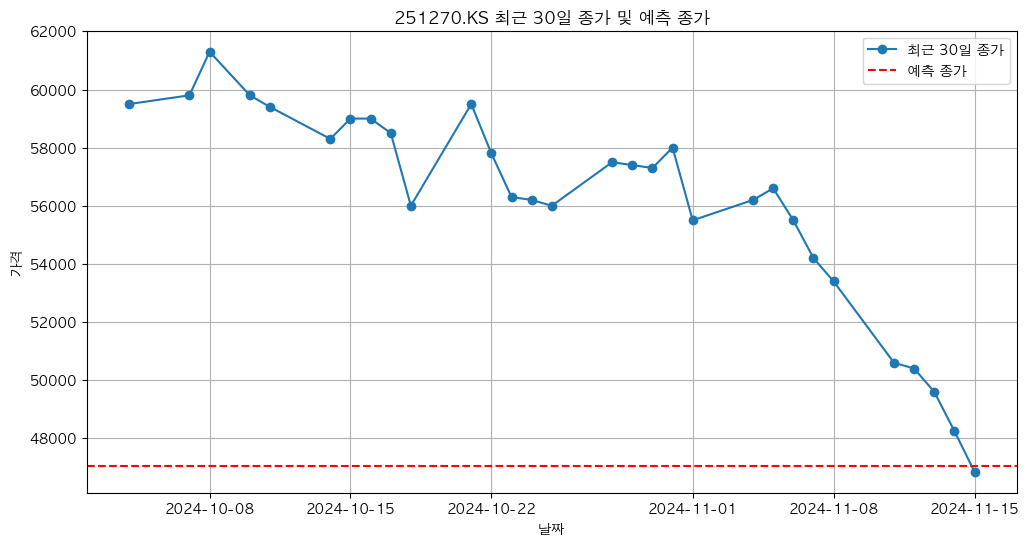

In [30]:
# 함수 실행
evaluate_stock("251270.KS")